# Vanilla auto encoder for feture extraction

### Attepmt to train the AutoEncoder (AE) as a feture extractor and improve for better classification 

**Overview** 
1. Undersample the class 8 to concner the inbalanced dataset
2. Train AutoEncoder with 7.5k training data with out label (Self-supervised)
3. Use that pre-trained AutoEncoder as a feture extractor and train both linear and fully connected model 

## GPUs information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 15 10:11:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required libraly

In [2]:
!pip install -q tfds-nightly tensorflow-datasets tensorflow matplotlib

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import misc

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization,Flatten, Reshape
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
ds = tfds.load('deep_weeds', batch_size = -1, as_supervised = True)

images, labels = ds['train']

## Undersample class 8 to avoid overfitting 

In [5]:
img_0 = tf.gather_nd(images, tf.where(labels == 0)).numpy()
img_1 = tf.gather_nd(images, tf.where(labels == 1)).numpy()
img_2 = tf.gather_nd(images, tf.where(labels == 2)).numpy()
img_3 = tf.gather_nd(images, tf.where(labels == 3)).numpy()
img_4 = tf.gather_nd(images, tf.where(labels == 4)).numpy()
img_5 = tf.gather_nd(images, tf.where(labels == 5)).numpy()
img_6 = tf.gather_nd(images, tf.where(labels == 6)).numpy()
img_7 = tf.gather_nd(images, tf.where(labels == 7)).numpy()
img_8 = tf.gather_nd(images, tf.where(labels == 8)).numpy()


label_0 = tf.gather_nd(labels, tf.where(labels == 0)).numpy()
label_1 = tf.gather_nd(labels, tf.where(labels == 1)).numpy()
label_2 = tf.gather_nd(labels, tf.where(labels == 2)).numpy()
label_3 = tf.gather_nd(labels, tf.where(labels == 3)).numpy()
label_4 = tf.gather_nd(labels, tf.where(labels == 4)).numpy()
label_5 = tf.gather_nd(labels, tf.where(labels == 5)).numpy()
label_6 = tf.gather_nd(labels, tf.where(labels == 6)).numpy()
label_7 = tf.gather_nd(labels, tf.where(labels == 7)).numpy()
label_8 = tf.gather_nd(labels, tf.where(labels == 8)).numpy()

img_sorted = [img_0, img_1, img_2, img_3, img_4, img_5, img_6, img_7, img_8]
label_sorted = [label_0, label_1, label_2, label_3, label_4, label_5, label_6, label_7, label_8]

In [6]:
print(img_0.shape)
print(img_1.shape)
print(img_2.shape)
print(img_3.shape)
print(img_4.shape)
print(img_5.shape)
print(img_6.shape)
print(img_7.shape)
print(img_8.shape)

(1125, 256, 256, 3)
(1064, 256, 256, 3)
(1031, 256, 256, 3)
(1022, 256, 256, 3)
(1062, 256, 256, 3)
(1009, 256, 256, 3)
(1074, 256, 256, 3)
(1016, 256, 256, 3)
(9106, 256, 256, 3)


In [7]:
new_img = []
new_label = []

count = 0
for img, label in zip(img_8, label_8):
  if(count >= 1000):
    break
  new_img.append(img)
  new_label.append(label)
  count += 1

new_img = np.array(new_img)
new_label = np.array(new_label)

print(new_img.shape)
print(new_label.shape)

(1000, 256, 256, 3)
(1000,)


In [8]:
concated_image = np.concatenate((img_0, img_1, img_2, img_3, img_4, img_5, img_6, img_7, new_img), axis=0)

In [9]:
concated_label = np.concatenate((label_0, label_1, label_2, label_3, label_4, label_5, label_6, label_7, new_label), axis=0)

In [10]:
concated_image.shape

(9403, 256, 256, 3)

In [11]:
concated_label.shape

(9403,)

In [12]:
train_X, test_X, train_y, test_y = train_test_split(concated_image, concated_label, test_size=0.2, random_state=0)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7522, 256, 256, 3)
(7522,)
(1881, 256, 256, 3)
(1881,)


In [13]:
def re_size(img, new_size):
    return cv2.resize(img, new_size)

In [14]:
resized_images = tf.image.resize(images, [32,32])


In [15]:
X_train = []
Y_train = []

X_test = []
Y_test = []



for each_x, each_y in zip(train_X, train_y):
    X_train.append(re_size(each_x, (128, 128)))
    Y_train.append(each_y)

for each_x, each_y in zip(test_X, test_y):
    X_test.append(re_size(each_x, (128, 128)))    
    Y_test.append(each_y)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

(128, 128, 3)


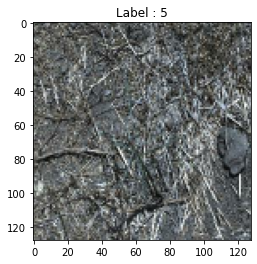

In [16]:
i = 43
fig , ax = plt.subplots()
ax.imshow(X_train[i])
plt.title("Label : " + str(Y_test[i]))
print(X_train[0].shape)

In [17]:
print("X train shape" + str(X_train.shape))
print("X test shape" + str(X_test.shape))

X train shape(7522, 128, 128, 3)
X test shape(1881, 128, 128, 3)


## Buliding the autoencoder

In [18]:
code_size = 1024


# Encoder---
input_layer = Input(shape=(128, 128, 3), name="INPUT")

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
#Latent space (Comressed fetures)
code_layer = Dense(code_size, name="CODE")(x)

# Decoder---
x = Dense(4096)(code_layer)
x = Reshape((16, 16, 16))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [19]:
weed_autoEncoder = Model(input_layer, output_layer)
weed_autoEncoder.compile(optimizer='adam', loss='mse')
weed_autoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624  

## Train the Auto encoder

In [20]:
weed_autoEncoder.fit(X_train, X_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
236/236 [==============================] - 9s 31ms/step - loss: 3012.3772 - val_loss: 2059.5825
Epoch 2/20
236/236 [==============================] - 7s 29ms/step - loss: 1906.7429 - val_loss: 1824.2249
Epoch 3/20
236/236 [==============================] - 7s 29ms/step - loss: 1748.1221 - val_loss: 1765.7678
Epoch 4/20
236/236 [==============================] - 7s 29ms/step - loss: 1678.6322 - val_loss: 1663.7618
Epoch 5/20
236/236 [==============================] - 7s 29ms/step - loss: 1630.9850 - val_loss: 1630.9646
Epoch 6/20
236/236 [==============================] - 7s 29ms/step - loss: 1577.8292 - val_loss: 1627.5231
Epoch 7/20
236/236 [==============================] - 7s 29ms/step - loss: 1543.4581 - val_loss: 1538.4763
Epoch 8/20
236/236 [==============================] - 7s 29ms/step - loss: 1505.9836 - val_loss: 1519.9015
Epoch 9/20
236/236 [==============================] - 7s 29ms/step - loss: 1481.5253 - val_loss: 1634.2756
Epoch 10/20
236/236 [================

##Show encoded image

In [21]:
from tensorflow.keras.preprocessing import image

In [22]:
weed_Encoder = Model(inputs=weed_autoEncoder.input, outputs=weed_autoEncoder.get_layer("CODE").output)

In [23]:
encoded_weed_train = weed_Encoder.predict(X_train)

In [24]:
#encoded_weed_train = encoded_weed_train.reshape((len(X_train), 32*32*8))
encoded_weed_train.shape

(7522, 1024)

In [25]:
encoded_weed_test = weed_Encoder.predict(X_test)
#encoded_weed_test = encoded_weed_test.reshape((len(X_test), 32*32*8))
encoded_weed_test.shape

(1881, 1024)

In [26]:
reconstructed_weed = weed_autoEncoder.predict(X_test[:10])

In [27]:
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

In [28]:
def show_cat_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        plt.title("Label" + str(Y_test[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

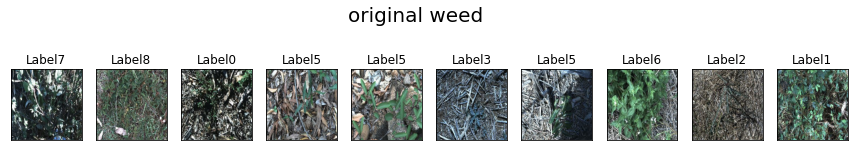

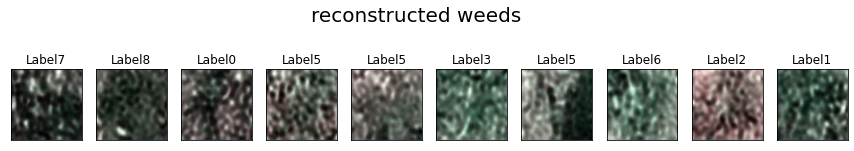

In [29]:
show_cat_data(X_test, title="original weed")
#show_data(encoded_weed_test, height=20, width=50, title="encoded weed (latent space representation)")
show_cat_data(reconstructed_weed, title="reconstructed weeds")

## Train linner model for classificatoin

Transform train image with a new feture z space (1024 fetures) 

In [30]:
X_train_new = weed_Encoder.predict(X_train)
X_test_new = weed_Encoder.predict(X_test)

y_train_new = train_y
y_test_new = test_y

print(X_train_new.shape)
print(y_train_new.shape)

print(X_test_new.shape)
print(y_test_new.shape)

(7522, 1024)
(7522,)
(1881, 1024)
(1881,)


### SVM

In [31]:
from sklearn import  svm

new_clf = svm.SVC(gamma="scale")
svm_model = new_clf.fit(X_train_new, y_train_new)
print('svm accuracy for training set: %f' % svm_model.score(X_train_new, y_train_new))
print('svm accuracy for test set: %f' % svm_model.score(X_test_new, y_test_new))

svm accuracy for training set: 0.583488
svm accuracy for test set: 0.346093


In [32]:
from sklearn.metrics import classification_report

y_pred = svm_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.35      0.31       227
           1       0.36      0.36      0.36       215
           2       0.38      0.58      0.46       199
           3       0.34      0.20      0.25       210
           4       0.30      0.33      0.32       196
           5       0.39      0.35      0.37       210
           6       0.43      0.56      0.49       230
           7       0.30      0.22      0.26       205
           8       0.22      0.12      0.16       189

    accuracy                           0.35      1881
   macro avg       0.33      0.34      0.33      1881
weighted avg       0.34      0.35      0.33      1881



### KNN

In [33]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors = 3, metric='euclidean')
knn_model = knn.fit(X_train_new, y_train_new)
print('kNN accuracy for training set: %f' % knn_model.score(X_train_new, y_train_new))
print('kNN accuracy for test set: %f' % knn_model.score(X_test_new, y_test_new))

kNN accuracy for training set: 0.472880
kNN accuracy for test set: 0.175970


In [34]:
y_pred = knn_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.16      0.16       227
           1       0.17      0.02      0.03       215
           2       0.16      0.60      0.26       199
           3       0.19      0.07      0.10       210
           4       0.13      0.09      0.10       196
           5       0.00      0.00      0.00       210
           6       0.23      0.13      0.17       230
           7       0.25      0.15      0.19       205
           8       0.17      0.42      0.24       189

    accuracy                           0.18      1881
   macro avg       0.16      0.18      0.14      1881
weighted avg       0.17      0.18      0.14      1881



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ramdom RandomForest 

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(X_train_new, y_train_new)
print('RandomForest accuracy for training set: %f' % rf_model.score(X_train_new, y_train_new))
print('RandomForest accuracy for test set: %f' % rf_model.score(X_test_new, y_test_new))

RandomForest accuracy for training set: 1.000000
RandomForest accuracy for test set: 0.316321


In [36]:
y_pred = rf_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.34      0.32       227
           1       0.26      0.23      0.24       215
           2       0.35      0.56      0.43       199
           3       0.24      0.16      0.19       210
           4       0.24      0.29      0.26       196
           5       0.34      0.29      0.31       210
           6       0.42      0.57      0.48       230
           7       0.35      0.23      0.28       205
           8       0.21      0.14      0.17       189

    accuracy                           0.32      1881
   macro avg       0.30      0.31      0.30      1881
weighted avg       0.31      0.32      0.30      1881



### Logistic regresion

In [37]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial')
lr_model = lr.fit(X_train_new, y_train_new)
print('LogisticRegression accuracy for training set: %f' % lr_model.score(X_train_new, y_train_new))
print('LogisticRegression accuracy for test set: %f' % lr_model.score(X_test_new, y_test_new))

LogisticRegression accuracy for training set: 0.401755
LogisticRegression accuracy for test set: 0.232855


In [38]:
y_pred = lr_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.29      0.27       227
           1       0.28      0.30      0.29       215
           2       0.28      0.24      0.26       199
           3       0.25      0.17      0.20       210
           4       0.10      0.09      0.10       196
           5       0.18      0.15      0.16       210
           6       0.31      0.43      0.36       230
           7       0.26      0.21      0.23       205
           8       0.14      0.16      0.15       189

    accuracy                           0.23      1881
   macro avg       0.23      0.23      0.22      1881
weighted avg       0.23      0.23      0.23      1881



## Fully connected layer 

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(248, activation='relu'),
    tf.keras.layers.Dense(248, activation='relu'),
    tf.keras.layers.Dense(9,  activation='softmax')
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.fit(X_train_new, y_train_new, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


236/236 [==============================] - 1s 2ms/step - loss: 9.6729 - accuracy: 0.1747
Epoch 2/10
236/236 [==============================] - 1s 2ms/step - loss: 2.2772 - accuracy: 0.3027
Epoch 3/10
236/236 [==============================] - 1s 2ms/step - loss: 1.6245 - accuracy: 0.4327
Epoch 4/10
236/236 [==============================] - 1s 2ms/step - loss: 1.3724 - accuracy: 0.5089
Epoch 5/10
236/236 [==============================] - 1s 2ms/step - loss: 1.1568 - accuracy: 0.5919
Epoch 6/10
236/236 [==============================] - 1s 2ms/step - loss: 1.1104 - accuracy: 0.6177
Epoch 7/10
236/236 [==============================] - 1s 2ms/step - loss: 1.0896 - accuracy: 0.6251
Epoch 8/10
236/236 [==============================] - 1s 2ms/step - loss: 1.0441 - accuracy: 0.6504
Epoch 9/10
236/236 [==============================] - 0s 2ms/step - loss: 1.1285 - accuracy: 0.6397
Epoch 10/10
236/236 [==============================] - 1s 2ms/step - loss: 1.0302 - accuracy: 0.6662


In [42]:
test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)

59/59 - 0s - loss: 4.3506 - accuracy: 0.2111 - 200ms/epoch - 3ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [43]:
y_pred = model.predict(X_test_new)

y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index

In [44]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(test_y, y_pred))

[0 7 1 ... 1 1 2]
              precision    recall  f1-score   support

           0       0.23      0.15      0.18       227
           1       0.22      0.28      0.24       215
           2       0.23      0.31      0.27       199
           3       0.15      0.13      0.14       210
           4       0.15      0.21      0.18       196
           5       0.12      0.07      0.09       210
           6       0.37      0.29      0.32       230
           7       0.20      0.32      0.25       205
           8       0.20      0.14      0.17       189

    accuracy                           0.21      1881
   macro avg       0.21      0.21      0.20      1881
weighted avg       0.21      0.21      0.21      1881

